# set file path

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Access files from Google Drive
file_path = '/content/drive/MyDrive/dataset folder/deap_dataset_1.mat'
print(file_path)

/content/drive/MyDrive/dataset folder/deap_dataset_1.mat


# import modules :

In [ ]:
# import packages, libraries
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

!pip install mne
import mne

#from scipy.signal import welch
import pywt
import scipy.io as sio

# classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score ,confusion_matrix

import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.ensemble import RandomForestClassifier

from sklearn.neighbors import KNeighborsClassifier

import time





# shape of dataset :

In [ ]:
dataset = scipy.io.loadmat(file_path)   #loading dataset
print("length of dataset : ",len(dataset)) #print length of data_dictionary
variables = dataset.keys()
print(variables)    #print data_dictionary keys

length of dataset :  5
dict_keys(['__header__', '__version__', '__globals__', 'labels', 'data'])


In [ ]:
labels_arr = dataset['labels']
print("label_shape",labels_arr.shape)

data_arr = dataset['data']
print("data shape ", data_arr.shape)

eeg_data_arr = data_arr[:, :-8, :]
print("eeg_data_shape", eeg_data_arr.shape)


label_shape (40, 4)
data shape  (40, 40, 8064)
eeg_data_shape (40, 32, 8064)


# Feature Extraction :

# 1)Hjorth_activity,mobility,complexity


In [ ]:
def compute_activity(data):
    activity = np.sum(np.abs(data), axis=2) / data.shape[2]         #axis = 2 means number of samples
    return activity

def compute_mobility(data):
    mobility = np.sqrt(np.var(data, axis=2))
    return mobility

def compute_complexity(data):
    gradients = np.gradient(data, axis=2)
    complexity = np.divide(np.sqrt(np.var(gradients, axis=2)), compute_mobility(data))
    return complexity

In [ ]:
mobility_array = compute_mobility(eeg_data_arr)
print(mobility_array.shape)

(40, 32)


# 2) first difference,normalized first difference

In [ ]:
def compute_sum_first_diff(data):
    first_diff = np.diff(data, axis=2)
    sum_first_diff = np.sum(first_diff, axis=2)
    return sum_first_diff


def compute_sum_normalized_first_diff(data):
    first_diff = np.diff(data, axis=2)
    normalized_first_diff = first_diff / np.std(first_diff, axis=2, keepdims=True)
    sum_normalized_first_diff = np.sum(normalized_first_diff, axis=2)
    return sum_normalized_first_diff


In [ ]:
first_di = compute_sum_first_diff(eeg_data_arr)
nm = compute_sum_normalized_first_diff(eeg_data_arr)
print(first_di.shape)
print(nm.shape)

(40, 32)
(40, 32)


# 3) band power

In [ ]:
def band_power_extraction(data, fs = 128):
    # Define the frequency bands
    frequency_bands = {
        'delta': (0.5, 4),
        'theta': (4, 8),
        'alpha': (8, 13),
        'beta': (13, 30),
        'gamma': (30, 45)
    }

    # Compute the power spectral density for each channel and trial
    num_trials, num_channels, num_samples = data.shape
    power_array = np.zeros((num_trials, num_channels, len(frequency_bands)))

    for trial_idx in range(num_trials):
        for channel_idx in range(num_channels):
            channel_data = data[trial_idx, channel_idx, :]
            for band_idx, (f_low, f_high) in enumerate(frequency_bands.values()):
                f, Pxx = welch(channel_data, fs=fs, nperseg=256, noverlap=128)
                power_array[trial_idx, channel_idx, band_idx] = np.sum(Pxx[(f >= f_low) & (f <= f_high)])

    return power_array


In [ ]:
band_powers = band_power_extraction(eeg_data_arr)

In [ ]:
band_powers.shape

(40, 32, 5)

In [ ]:
array1 = band_powers[..., 0]
array2 = band_powers[..., 1]
array3 = band_powers[..., 2]
array4 = band_powers[..., 3]
array5 = band_powers[..., 4]

In [ ]:
array1.shape

(40, 32)

In [ ]:
print(array1[0,0])
array1[0,1]

0.39270860786206646


0.7355315897436678

# 4) HOC

In [ ]:
#import numpy as np

def compute_higher_order_crossing(data, threshold=0):
    binary_sequence = np.sign(data - threshold)
    crossings = np.sum(np.abs(np.diff(binary_sequence, axis=2)), axis=2) / 2
    return crossings

hoc_result = compute_higher_order_crossing(eeg_data_arr)

# Print the shape of the resulting HOC array
print(hoc_result.shape)


(40, 32)


In [ ]:
print(hoc_result[0,0])
print(hoc_result[10,30])

1963.0
1620.0


#  5) DWT - RMS, RRE

In [ ]:
def calculate_dwt_rms(data):
    trials, channels, samples = data.shape
    rms_values = np.zeros((trials, channels))

    for trial in range(trials):
        for channel in range(channels):
            dwt_coeffs = pywt.dwt(data[trial, channel, :], 'db1')  # Perform DWT using 'db1' wavelet
            dwt_rms = np.sqrt(np.mean(np.square(dwt_coeffs)))
            rms_values[trial, channel] = dwt_rms

    return rms_values



def calculate_dwt_ree(data):
    trials, channels, samples = data.shape
    ree_values = np.zeros((trials, channels))

    for trial in range(trials):
        for channel in range(channels):
            dwt_coeffs = pywt.dwt(data[trial, channel, :], 'db1')  # Perform DWT using 'db1' wavelet
            energy = np.sum(np.square(dwt_coeffs))
            ree = energy / (samples * np.var(data[trial, channel, :]))
            ree_values[trial, channel] = ree

    return ree_values



In [ ]:
root_mean_sq = calculate_dwt_rms(eeg_data_arr)
print(root_mean_sq.shape)


Ree = calculate_dwt_ree(eeg_data_arr)
print(Ree.shape)

(40, 32)
(40, 32)


# concatenate all features

In [ ]:
def concatenate_features_(data):
    activity = compute_activity(data)
    mobility = compute_mobility(data)
    complexity = compute_complexity(data)
    sum_first_diff = compute_sum_first_diff(data)
    sum_normalized_first_diff = compute_sum_normalized_first_diff(data)
    higher_order_crossing = compute_higher_order_crossing(data, threshold=0)
    dwt_ree = calculate_dwt_ree(data)
    dwt_rms =calculate_dwt_rms(data)


    print("Shape of activity:", activity.shape)
    print("Shape of mobility:", mobility.shape)
    print("Shape of complexity:", complexity.shape)
    print("Shape of sum_first_diff:", sum_first_diff.shape)
    print("Shape of sum_normalized_first_diff:", sum_normalized_first_diff.shape)
    print("Shape of higher_order_crossing:", higher_order_crossing.shape)
    print("shape of dwt_rms:",dwt_rms.shape)
    print("shape of dwt_ree:",dwt_ree.shape)

    # Perform the concatenation
    features = np.concatenate((activity, mobility, complexity, sum_first_diff,
                               sum_normalized_first_diff, higher_order_crossing,
                               array1, array2, array3, array4, array5,
                               dwt_rms, dwt_ree), axis=-1)

    return features
final = concatenate_features_(eeg_data_arr)
print("\nfinal_features_shape",final.shape)

Shape of activity: (40, 32)
Shape of mobility: (40, 32)
Shape of complexity: (40, 32)
Shape of sum_first_diff: (40, 32)
Shape of sum_normalized_first_diff: (40, 32)
Shape of higher_order_crossing: (40, 32)
shape of dwt_rms: (40, 32)
shape of dwt_ree: (40, 32)

final_features_shape (40, 416)


#save  extracted features as a  .mat file  :

In [ ]:
features_file_path = '/content/drive/MyDrive/dataset folder/deap_features_1.mat'
sio.savemat(features_file_path, {'deap_1_features': final})

save labels as a .mat file :

In [ ]:
valance,ars,dom,lh = labels_arr[:, 0] , labels_arr[:,1],labels_arr[:,2],labels_arr[:,3]
print(valance.shape, ars.shape ,dom.shape, lh.shape)

valance_2D , ars_2d , dom_2d , lh_2d = valance.reshape((40, 1)),ars.reshape(40,1),dom.reshape(40,1),lh.reshape(40,1)


(40,) (40,) (40,) (40,)


In [ ]:
label_file_path = '/content/drive/MyDrive/dataset folder/labels_deap_1.mat'
sio.savemat(label_file_path, {'labels_v': valance_2D , 'labels_a': ars_2d ,'labels_d' :dom_2d ,'labels_l' :lh_2d})

# discrete labels :

In [ ]:
# Define the thresholds for the discrete labels
average = np.mean(valance_2D )
print("average valance is : " , average,"\n")

# Define the labels for each range
label_low = "Low"
label_high = "High"

# Function to convert continuous label to discrete label
def convert_label(value):
    if value < average:
        return label_low
    else:
        return label_high

# Iterate over each label and convert it to the discrete label
discrete_labels = [convert_label(label) for label in valance_2D ]

# Print the converted labels for first 5 viedos
for i in range(5):
    print(f"Original label: {valance_2D [i]}, Converted label: {discrete_labels[i]}")

discrete_labels_valance = np.array(discrete_labels)                     # shape------(40,)

#discrete_labels_array = np.reshape(discrete_labels_array, (-1, 1))   # shape ------------ (40,1)

print("\n shape of discrete_labels array ",discrete_labels_valance.shape)
print("\n",discrete_labels_valance)


average valance is :  5.117749999999999 

Original label: [7.71], Converted label: High
Original label: [8.1], Converted label: High
Original label: [8.58], Converted label: High
Original label: [4.94], Converted label: Low
Original label: [6.96], Converted label: High

 shape of discrete_labels array  (40,)

 ['High' 'High' 'High' 'Low' 'High' 'High' 'High' 'High' 'Low' 'Low' 'Low'
 'Low' 'Low' 'Low' 'Low' 'High' 'Low' 'High' 'High' 'High' 'High' 'High'
 'High' 'High' 'High' 'High' 'High' 'Low' 'Low' 'Low' 'Low' 'Low' 'Low'
 'Low' 'Low' 'Low' 'Low' 'Low' 'Low' 'Low']


In [ ]:
# Define the thresholds for the discrete labels
average = np.mean(ars_2d)
print("average valance is : " , average,"\n")

# Define the labels for each range
label_low = "Low"
label_high = "High"

# Function to convert continuous label to discrete label
def convert_label(value):
    if value < average:
        return label_low
    else:
        return label_high

# Iterate over each label and convert it to the discrete label
discrete_labels = [convert_label(label) for label in ars_2d ]

# Print the converted labels for first 5 viedos
for i in range(5):
    print(f"Original label: {ars_2d [i]}, Converted label: {discrete_labels[i]}")

discrete_labels_ars = np.array(discrete_labels)                     # shape------(40,)

#discrete_labels_array = np.reshape(discrete_labels_array, (-1, 1))   # shape ------------ (40,1)

print("\n shape of discrete_labels array ",discrete_labels_ars.shape)
print("\n",discrete_labels_ars)


average valance is :  5.65975 

Original label: [7.6], Converted label: High
Original label: [7.31], Converted label: High
Original label: [7.54], Converted label: High
Original label: [6.01], Converted label: High
Original label: [3.92], Converted label: Low

 shape of discrete_labels array  (40,)

 ['High' 'High' 'High' 'High' 'Low' 'Low' 'Low' 'Low' 'Low' 'Low' 'Low'
 'Low' 'Low' 'Low' 'High' 'High' 'High' 'High' 'High' 'High' 'High' 'Low'
 'Low' 'High' 'High' 'High' 'High' 'Low' 'Low' 'Low' 'High' 'High' 'Low'
 'High' 'High' 'High' 'High' 'High' 'High' 'High']


In [ ]:
print(final.shape)
print(valance_2D.shape)
print(discrete_labels_valance.shape)

(40, 416)
(40, 1)
(40,)


#Classification :

In [ ]:
final.shape

(40, 416)

In [ ]:
features = final
features.shape

(40, 416)

# 1) Logistic Regression :

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.5833333333333334
[[5 2]
 [3 2]]


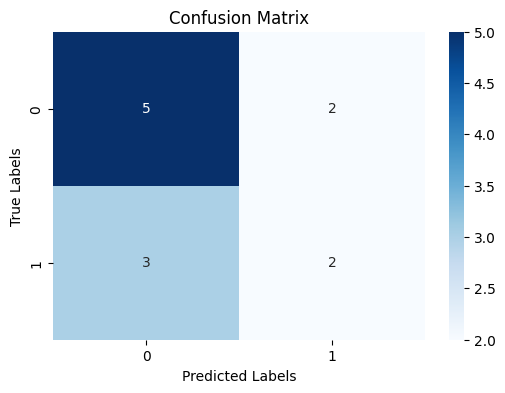



Runtime: 0.3110377788543701 seconds


In [ ]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, discrete_labels_ars, test_size=0.3, random_state=42)

# Create a Logistic Regression model
model = LogisticRegression()

start_time = time.time()

# Train the model
model.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print("Accuracy:", accuracy)
cm = confusion_matrix(y_test, y_pred)
print(cm)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


end_time = time.time()
runtime = end_time - start_time
print("\n\nRuntime:", runtime, "seconds")

In [ ]:
print(X_test.shape)
print(X_train.shape)
print(y_train.shape)
print(y_test.shape)
print("\n original   : predicted \n" )
for i in range(len(y_pred)):
  print(y_test[i] ," : " , y_pred[i])

(12, 416)
(28, 416)
(28,)
(12,)

 original   : predicted 

High  :  High
High  :  High
High  :  Low
High  :  Low
Low  :  Low
Low  :  High
High  :  High
Low  :  Low
High  :  High
Low  :  High
High  :  High
Low  :  High


# 2) SVM :

Best parameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
Accuracy: 0.5833333333333334
[[6 1]
 [4 1]]


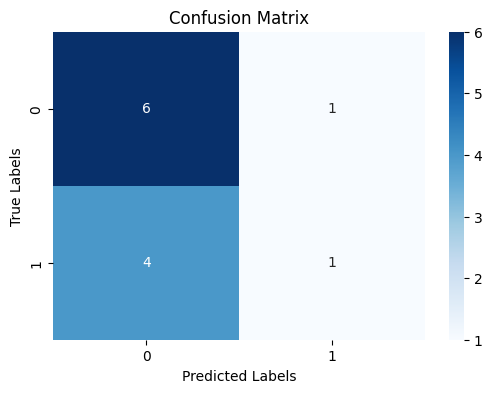

x_test (12, 416)
x_train (28, 416)
y_train (28,)
y_test (12,)

 original : predicted 

High  :  High
High  :  High
High  :  High
High  :  Low
Low  :  High
Low  :  High
High  :  High
Low  :  Low
High  :  High
Low  :  High
High  :  High
Low  :  High


Runtime: 0.63875412940979 seconds


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features,discrete_labels_ars, test_size=0.3, random_state=42)

# Define the parameter grid for grid search
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

# Create an SVM model
model = SVC()

start_time = time.time()

# Perform grid search with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Predict the labels for the test set
y_pred = best_model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

# Print the best parameters and accuracy
print("Best parameters:", grid_search.best_params_)
print("Accuracy:", accuracy)
cm = confusion_matrix(y_test, y_pred)
print(cm)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
print("x_test",X_test.shape)
print( "x_train",X_train.shape)
print("y_train",y_train.shape)
print("y_test",y_test.shape)
print("\n original : predicted \n")
for i in range(len(y_pred)):
  print(y_test[i] ," : " , y_pred[i])

end_time = time.time()
runtime = end_time - start_time
print("\n\nRuntime:", runtime, "seconds")

# 3) Random forest :

Accuracy: 0.625
Confusion Matrix:
[[3 2]
 [1 2]]


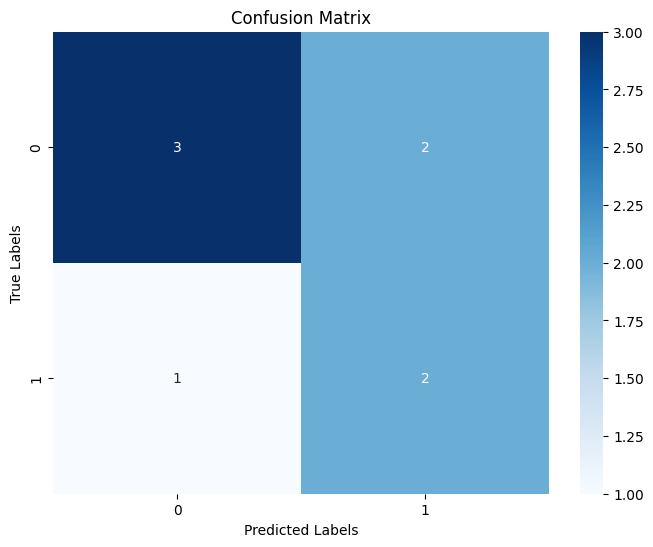



Runtime: 0.8214762210845947 seconds


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features,discrete_labels_ars, test_size=0.2, random_state=42)

# Create the Random Forest classifier
rf_classifier = RandomForestClassifier()

start_time = time.time()

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_classifier.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion_mat)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


end_time = time.time()
runtime = end_time - start_time
print("\n\nRuntime:", runtime, "seconds")

In [ ]:
print("x_test",X_test.shape)
print( "x_train",X_train.shape)
print("y_train",y_train.shape)
print("y_test",y_test.shape)
print("\n original : predicted \n")
for i in range(8):
  print(y_test[i] ," : " , y_pred[i])

x_test (8, 416)
x_train (32, 416)
y_train (32,)
y_test (8,)

 original : predicted 

High  :  High
High  :  High
High  :  High
High  :  Low
Low  :  High
Low  :  Low
High  :  Low
Low  :  Low


# 4) KNN :

Accuracy: 0.875
Confusion Matrix:
[[5 0]
 [1 2]]


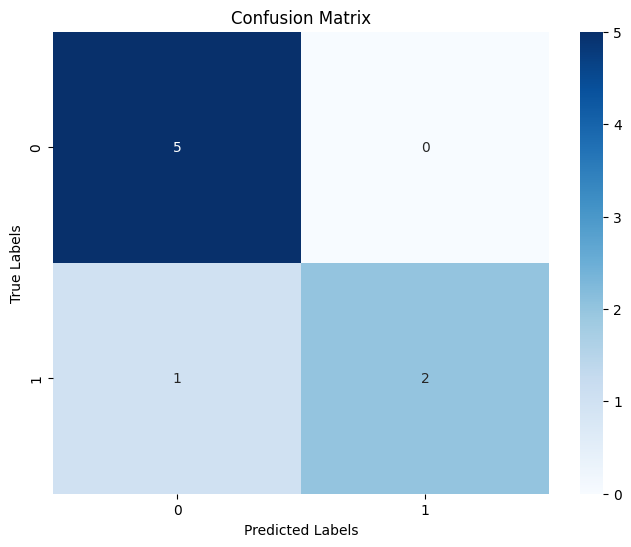



Runtime: 0.2690846920013428 seconds


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features,discrete_labels_ars, test_size=0.2, random_state=42)

# Create the KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)  # n_neighbors is the number of nearest neighbors to consider

start_time = time.time()

# Train the classifier on the training data
knn_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = knn_classifier.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion_mat)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

end_time = time.time()
runtime = end_time - start_time
print("\n\nRuntime:", runtime, "seconds")

In [ ]:
print("x_test",X_test.shape)
print( "x_train",X_train.shape)
print("y_train",y_train.shape)
print("y_test",y_test.shape)
print("\n original : predicted \n")
for i in range(8):
  print(y_test[i] ," : " , y_pred[i])

x_test (8, 416)
x_train (32, 416)
y_train (32,)
y_test (8,)

 original : predicted 

High  :  High
High  :  High
High  :  High
High  :  High
Low  :  Low
Low  :  High
High  :  High
Low  :  Low


In [ ]:
'''

kNN  :    0.875                Runtime: 0.2690846920013428 seconds

RF   :     0.75                Runtime: 0.8214762210845947 seconds

svm  :    0.58333..            Runtime: 0.63875412940979 seconds

LR   :    0.58333..            Runtime: 0.3110377788543701 seconds

'''

'\n\nkNN  :    0.875                Runtime: 0.2690846920013428 seconds\n\nRF   :     0.75                Runtime: 0.8214762210845947 seconds\n\nsvm  :    0.58333..            Runtime: 0.63875412940979 seconds\n\nLR   :    0.58333..            Runtime: 0.3110377788543701 seconds\n\n'